In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import dataloader
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from scipy.special import softmax

from action_utils import *
from two_stream_loader import *

In [2]:
dataloader = dataloader.spatial_dataloader(BATCH_SIZE=1, num_workers=1, 
                                           path='/mnt/disks/datastorage/videos/rgb/', 
                                           ucf_list='/home/mlp/two-stream-action-recognition/UCF_list/',
                                           ucf_split='01')
train_loader,val_loader,test_video = dataloader.run()

Spatial Dataloader Initialized
==> (Training video, Validation video):( 899 183 )
==> sampling testing frames
Spatial train Dataset Initialized
==> Training data : 899 frames
Spatial val Dataset Initialized
==> Validation data : 3477 frames


In [3]:
frame_count = dataloader.frame_count

In [4]:
dataloader.dic_training

{'Theft_g04_c000002 121': 1,
 'Misc_g10_c000002 138': 4,
 'Theft_g05_c000026 122': 1,
 'Shooting_g03_c000008 129': 3,
 'Shooting_g04_c000024 132': 3,
 'Shooting_g02_c000025 126': 3,
 'Misc_g13_c000011 128': 4,
 'Shooting_g02_c000018 130': 3,
 'Assault_g04_c000005 132': 2,
 'Shooting_g05_c000023 112': 3,
 'Assault_g04_c000014 117': 2,
 'Misc_g13_c000014 127': 4,
 'Theft_g05_c000024 123': 1,
 'Shooting_g10_c000002 56': 3,
 'Shooting_g01_c000008 121': 3,
 'Shooting_g10_c000008 134': 3,
 'Theft_g05_c000047 52': 1,
 'Assault_g01_c000004 118': 2,
 'Shooting_g02_c000033 122': 3,
 'Assault_g12_c000009 125': 2,
 'Theft_g03_c000033 59': 1,
 'Misc_g02_c000019 120': 4,
 'Misc_g01_c000018 126': 4,
 'Shooting_g05_c000043 114': 3,
 'Assault_g05_c000007 132': 2,
 'Shooting_g04_c000018 122': 3,
 'Misc_g13_c000001 64': 4,
 'Shooting_g05_c000002 57': 3,
 'Assault_g14_c000005 126': 2,
 'Shooting_g03_c000010 129': 3,
 'Assault_g05_c000015 126': 2,
 'Misc_g03_c000002 134': 4,
 'Misc_g05_c000023 123': 4,
 'S

In [5]:
dic_training = dataloader.dic_training.copy()

dic_testing = {}
for key,value in test_video.items():
    dic_testing[key+" "+str(frame_count[key]-10+1)] = value

In [6]:
print(len(dic_training))
print(len(dic_testing))
#dic_training.update(dic_testing)
print(len(dic_training))
print(len(dataloader.dic_training))

899
183
899
899


# Generate Dataset Randomly

In [7]:
def stack_op(imgs_u,imgs_v,i):
    _, img_rows, img_cols = imgs_u[0].shape
    flow = torch.FloatTensor(2*10,img_rows,img_cols)

    for j in range(i, 10+i):
        H = imgs_u[j]
        V = imgs_v[j]

        flow[2*(j-1-i),:,:] = H
        flow[2*(j-1-i)+1,:,:] = V

    flow = flow.unsqueeze(0)
    
    return flow

In [8]:
path_temporal = r"/mnt/disks/datastorage/videos/flownet2/"
path_spatial = r"/mnt/disks/datastorage/videos/rgb/"

In [9]:
[temporal_net,spatial_net] =load_models(path_spatial,path_temporal)

Dropout is  0
Dropout is  0


In [10]:
nSamples = 15
spatial_net.eval()
temporal_net.eval()

X_train = np.empty((0,8), float)
y_train = np.empty((0),int)

for key,value in dic_training.items():
    video_name,nb_frames = key.split(' ')
    nb_frames = int(nb_frames)
    
    try:
        imgs_u,imgs_v = load_temporal_images(path_temporal,"v_"+video_name)
        imgs_spatial = load_spatial_images(path_spatial,"v_"+video_name)
    except:
        print("Skipped ",video_name)
        continue
    
#     print(video_name,nb_frames)
    for i in range(nSamples):
#         print(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)
#         print(np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples))
        idx = np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)

        p_spatial = spatial_net.forward(imgs_spatial[idx].unsqueeze(0).cuda()).cpu().detach().numpy().squeeze()
        p_spatial = softmax(p_spatial)
        
        flow = stack_op(imgs_u,imgs_v,idx)
        p_temporal = temporal_net.forward(flow.cuda()).cpu().detach().numpy().squeeze()
        p_temporal = softmax(p_temporal)


        p = np.hstack((p_spatial,p_temporal))
        
        y_train = np.hstack((y_train,value))
        X_train = np.vstack((X_train,p))

In [11]:
print(X_train.shape)
print(y_train.shape)

(13485, 8)
(13485,)


In [12]:
# save dataset
training_set = {"Data":X_train,"Labels":y_train}
with open('Training_Set2.pickle','wb') as handle:
    pickle.dump(training_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# load dataset
with open('Training_Set2.pickle', 'rb') as handle:
    training_set = pickle.load(handle)
X_train = training_set["Data"]
y_train = training_set["Labels"]

In [34]:
nSamples = 15
spatial_net.eval()
temporal_net.eval()

X_test = np.empty((0,8), float)
y_test = np.empty((0),int)

for key,value in dic_testing.items():
    video_name,nb_frames = key.split(' ')
    nb_frames = int(nb_frames)
    
    try:
        imgs_u,imgs_v = load_temporal_images(path_temporal,"v_"+video_name)
        imgs_spatial = load_spatial_images(path_spatial,"v_"+video_name)
    except:
        print("Skipped ",video_name)
        continue
    
#     print(video_name,nb_frames)
    for i in range(nSamples):
#         print(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)
#         print(np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples))
        idx = np.random.randint(i*nb_frames/nSamples,(i+1)*nb_frames/nSamples)

        p_spatial = spatial_net.forward(imgs_spatial[idx].unsqueeze(0).cuda()).cpu().detach().numpy().squeeze()
        p_spatial = softmax(p_spatial)
        
        flow = stack_op(imgs_u,imgs_v,idx)
        p_temporal = temporal_net.forward(flow.cuda()).cpu().detach().numpy().squeeze()
        p_temporal = softmax(p_temporal)


        p = np.hstack((p_spatial,p_temporal))
        
        y_test = np.hstack((y_test,value))
        X_test = np.vstack((X_test,p))

In [35]:
# save dataset
testing_set = {"Data":X_test,"Labels":y_test}
with open('Testing_Set2.pickle','wb') as handle:
    pickle.dump(testing_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# load dataset
with open('Testing_Set2.pickle', 'rb') as handle:
    testing_set = pickle.load(handle)
X_test = testing_set["Data"]
y_test = testing_set["Labels"]

In [37]:
print(X_test.shape)
print(y_test.shape)

(2745, 8)
(2745,)


In [18]:
print(X_train.shape)
print(y_train.shape)

(13485, 8)
(13485,)


## SVM

In [19]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [62]:
from sklearn import svm, datasets
from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

clf = svm.SVC(probability=True)


# specify parameters and distributions to sample from
param_dist = {"kernel":('rbf','poly'),
              "degree": sp_randint(2, 11),
              "C": uniform(0.1, 15),
              "gamma": uniform(0.1, 1)}

n_iter_search = 1000
loss = "neg_log_loss"
#loss='f1_macro'
#loss = 'precision'
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False,scoring=loss)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 14477.63 seconds for 1000 candidates parameter settings.


In [63]:
report(random_search.cv_results_,10)

Model with rank: 1
Mean validation score: -0.113 (std: 0.036)
Parameters: {'C': 11.778497884757801, 'degree': 4, 'gamma': 0.46564504561048714, 'kernel': 'poly'}

Model with rank: 2
Mean validation score: -0.114 (std: 0.035)
Parameters: {'C': 13.182086795035497, 'degree': 4, 'gamma': 0.448193894782164, 'kernel': 'poly'}

Model with rank: 3
Mean validation score: -0.114 (std: 0.037)
Parameters: {'C': 14.013775523379325, 'degree': 4, 'gamma': 0.4738980493772824, 'kernel': 'poly'}

Model with rank: 4
Mean validation score: -0.114 (std: 0.037)
Parameters: {'C': 3.368724916920518, 'degree': 4, 'gamma': 0.66002667772904, 'kernel': 'poly'}

Model with rank: 5
Mean validation score: -0.114 (std: 0.035)
Parameters: {'C': 14.534859739416694, 'degree': 5, 'gamma': 0.5026761531054568, 'kernel': 'poly'}

Model with rank: 6
Mean validation score: -0.114 (std: 0.033)
Parameters: {'C': 13.169692609455751, 'degree': 5, 'gamma': 0.48300967990192445, 'kernel': 'poly'}

Model with rank: 7
Mean validation s

In [64]:
# will take around 30 minutes to run for 1000 iterations... :(

In [65]:
best_clf = random_search.best_estimator_

In [66]:
y_pred = best_clf.predict(X_test)

In [67]:
X_rgb = X_test[:,0:4]
X_opf = X_test[0:,4:8]

In [68]:
print(X_rgb.shape)
print(X_opf.shape)

(2745, 4)
(2745, 4)


In [69]:
y_rgb = X_rgb.argmax(1)+1
y_opf = X_opf.argmax(1)+1

In [70]:
y_c = (X_rgb + X_opf).argmax(1)+1

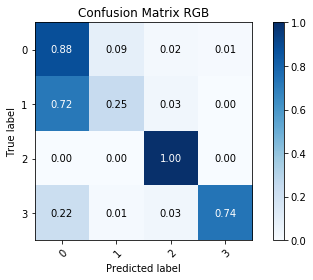

In [71]:
cm = confusion_matrix(y_test, y_pred)
# cm = confusion_matrix(y_test, y_rgb)
# cm = confusion_matrix(y_test, y_opf)

#cm = confusion_matrix(y_test, y_c)



cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

classes = np.arange(0,4)

cmap = plt.cm.Blues
#title = 'Confusion Matrix Combined'
title = 'Confusion Matrix RGB'
#title = 'Confusion Matrix OPF'


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

## Save the best model :)

In [38]:
model_pickle_name = "svm_model2.pkl"
with open(model_pickle_name, 'wb') as file:
    pickle.dump(best_clf, file)

# Load the best model :)

In [39]:
# Load from file
model_pickle_name = "svm_model2.pkl"
with open(model_pickle_name, 'rb') as file:
    pickle_model = pickle.load(file)